In [1]:
filename = r'C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2.dat'

In [2]:
run_id = 1

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tables

In [4]:
import phconvert as phc
phc.__version__

'0.5.3-7-gc062ec1'

In [5]:
import time

class Timer:
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start

##Load FRETBursts software

In [6]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
-------------------------------------------------------------
 You are running FRETBursts (version 0.4.1-1-gcaa3c4c).

 If you use this software in a publication, please cite it as:

   FRETBursts - An opensource single-molecule FRET bursts analysis toolkit.
   A. Ingargiola 2014. https://github.com/tritemio/FRETBursts

-------------------------------------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# DCR files

In [7]:
d = loader.multispot8(filename)

 - File loaded from cache: C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2.dat


In [8]:
d.ph_data_sizes.sum()

89476559

In [9]:
d.time_max

3887.3445987124996

## Read the original data

In [10]:
with Timer('mspot_read_speed_native') as t:
    timestamps_m, A_em, _ = loader.load_data_ordered16(fname=filename, swap_D_A=False)

 - Loading data "C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2.dat" ...  [DONE]
 - Processing data ...    [DONE Processing]


In [11]:
read_speed_native_numpy = pd.DataFrame({'native_numpy': t.interval}, index=[0])
read_speed_native_numpy

,native_numpy
0,15.034636


In [12]:
with Timer('mspot_read_speed_native_swap') as t:
    timestamps_m, A_em, _ = loader.load_data_ordered16(fname=filename, swap_D_A=True)

 - Loading data "C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2.dat" ...  [DONE]
 - Processing data ... 
   - Swapping D and A channels ...  [DONE]
   [DONE Processing]


In [13]:
read_speed_native_numpy_swap = pd.DataFrame({'native_numpy': t.interval}, index=[0])
read_speed_native_numpy_swap

,native_numpy
0,10.698903


## Meatadata

In [14]:
ts_unit = 12.5e-9

In [15]:
acquisition_time = np.max([t[-1] - t[0] for t in timestamps_m])*ts_unit 
comment = 'DCR measurement for two 8-pixel POLIMI SPAD arrays (octopus).'

setup = dict(num_pixels = 16)
provenance = dict(filename=filename, software='phconvert', software_version=phc.__version__)

data = dict(
    _filename = filename,
    acquisition_time = round(acquisition_time),
    comment=comment,
    setup=setup,
    provenance=provenance)

for ich, (times, a_em) in enumerate(zip(timestamps_m, A_em)):
    data.update(**{
            'photon_data%d' % ich: 
            dict(
                timestamps = times,
                timestamps_specs = dict(timestamps_unit=ts_unit),
                detectors = a_em.view('uint8'))})

In [16]:
data.keys()

['comment',
 'acquisition_time',
 '_filename',
 'setup',
 'provenance',
 'photon_data7',
 'photon_data6',
 'photon_data5',
 'photon_data4',
 'photon_data3',
 'photon_data2',
 'photon_data1',
 'photon_data0']

In [17]:
phc.hdf5.assert_valid_photon_hdf5(data, strict=False)

Photon-HDF5 WARNING: Missing measurement_specs in /photon_data.
Photon-HDF5 WARNING: Missing "/setup/num_spots".
Photon-HDF5 WARNING: Missing "/setup/num_spectral_ch".
Photon-HDF5 WARNING: Missing "/setup/num_polarization_ch".
Photon-HDF5 WARNING: Missing "/setup/num_split_ch".
Photon-HDF5 WARNING: Missing "/setup/modulated_excitation".
Photon-HDF5 WARNING: Missing "/setup/lifetime".


# Save to Photon-HDF5

In [18]:
write_speed_ = {}
file_size_ = {}
for complib in ['zlib', 'blosc']:
    for complevel in range(0, 10):
        compression = {'complevel': complevel, 'complib': complib}
        fn = "%s_%s%d.hdf5" % (filename[:-4], complib, complevel)
        print (fn)
        with Timer(fn) as t:
            phc.hdf5.save_photon_hdf5(data, close=True, h5_fname=fn, compression=compression)
        write_speed_[(complib, complevel)] = t
        file_size_[(complib, complevel)] = os.path.getsize(fn)

C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib0.hdf5
Saving: C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib0.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib1.hdf5
Saving: C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib1.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib2.hdf5
Saving: C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib2.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib3.hdf5
Saving: C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib3.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib4.hdf5
Saving: C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib4.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib5.hdf5
Saving: C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib5.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26

In [19]:
t_blosc = [write_speed_[key].interval for key in sorted(write_speed_.keys())if key[0] == 'blosc']
t_zlib = [write_speed_[key].interval for key in sorted(write_speed_.keys())if key[0] == 'zlib']

size_blosc = [file_size_[key] for key in sorted(file_size_.keys())if key[0] == 'blosc']
size_zlib = [file_size_[key] for key in sorted(file_size_.keys())if key[0] == 'zlib']

In [25]:
write_speed = pd.DataFrame({'zlib': t_zlib, 'blosc': t_blosc})
file_size = pd.DataFrame({'zlib': size_zlib, 'blosc': size_blosc})
file_size['native'] = os.path.getsize(filename)

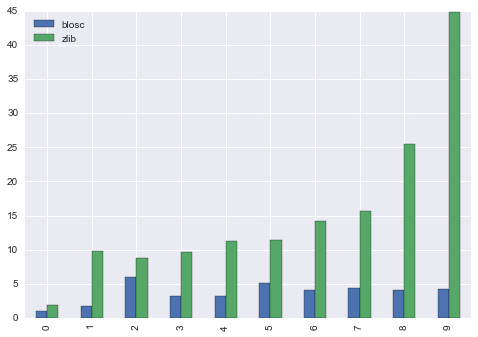

In [21]:
write_speed.plot(kind='bar')

(0, 5)

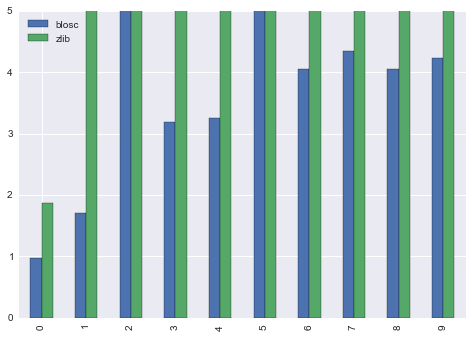

In [22]:
write_speed.plot(kind='bar')
plt.ylim(0, 5)

In [ ]:
write_speed.to_hdf('benchmark%d.h5' % run_id, key='mspot_write_speed')

In [26]:
file_size.to_hdf('benchmark%d.h5' % run_id, key='mspot_file_size')

In [ ]:
1

# Read speed

In [27]:
#filename = r"C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2.hdf5"

In [28]:
read_speed_ = {}
#cache = []
for complib in ['zlib', 'blosc']:
    for complevel in range(0, 9):
        fn = "%s_%s%d.hdf5" % (filename[:-4], complib, complevel)
        print (fn)
        assert os.path.exists(fn)
        with Timer(fn) as t:
            
            with tables.open_file(fn) as h5:
                for ph_data in h5.root._f_iter_nodes():
                    if not ph_data._v_name.startswith('photon_data'): continue
                    a = ph_data.timestamps.read()
                    b = ph_data.detectors.read()
                
        #cache.append((a,b,c))        
        read_speed_[(complib, complevel)] = t
#del cache

C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib0.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib1.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib2.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib3.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib4.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib5.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib6.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib7.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_zlib8.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_blosc0.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_blosc1.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_blosc2.hdf5
C:\Data\Antonio\data\8-spot 5samples data\2014-02-26\DCR_test_2_blosc3.hdf5
C:\Data\Antonio\data\

In [29]:
t_blosc = [read_speed_[key].interval for key in sorted(read_speed_.keys())if key[0] == 'blosc']
t_zlib = [read_speed_[key].interval for key in sorted(read_speed_.keys())if key[0] == 'zlib']

In [30]:
read_speed = pd.DataFrame({'zlib': t_zlib, 'blosc': t_blosc})

In [31]:
read_speed = read_speed.join(read_speed_native_numpy)

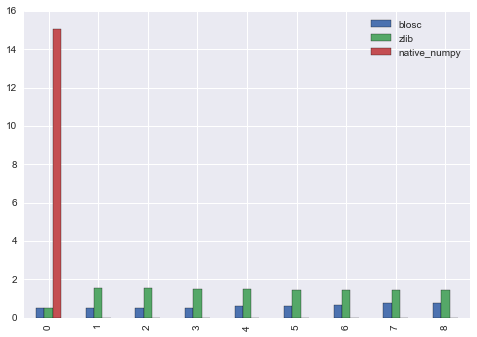

In [32]:
read_speed.plot(kind='bar')

In [33]:
read_speed.to_hdf('benchmark%d.h5' % run_id, key='mspot_read_speed')

In [34]:
# import h5py
# h5 = h5py.File(filename)
# %%timeit
# with h5py.File(filename) as h5:
#     for name, value in h5.items():
#             if not name.startswith('photon_data'): continue
#             value['timestamps'][:]
#             value['detectors'][:]

# Benchmark Summary

Multi-spot DAT file (8-spot) 32bit per photon, requiring overflow correction. File contains 89.5 million photons.

In [35]:
read_speed_dat = 10.8
read_speed_pytables = 1.42
read_speed_h5py = 1.38